### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

sns.set_style("whitegrid")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.6.0


### Directories

In [2]:
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /workspaces/ML_Project_Image_Recognition/Jupyter_Notebooks


In [3]:
os.chdir('/workspaces/ML_Project_Image_Recognition')
print("New working directory set.")

New working directory set.


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/ML_Project_Image_Recognition'

### Outputs

In [5]:
data_dir = 'inputs/cracks_dataset_new'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')
test_path = os.path.join(data_dir, 'test')

version = 'v1'
output_path = os.path.join('outputs', version)
os.makedirs(output_path, exist_ok=True)
print(f"Output folder: {output_path}")

Output folder: outputs/v1


In [6]:
image_shape = joblib.load(f'{output_path}/image_shape.pkl')
print("Image shape loaded:", image_shape)

class_indices = joblib.load(f'{output_path}/class_indices.pkl')
labels = list(class_indices.keys())
print("Class labels:", labels)

Image shape loaded: (256, 256, 3)
Class labels: ['Cracked', 'Non-cracked']


### Augmentation 
 - Augmenting only the "Cracked" images to create image diversity when training as the disparity between cracked and non-cracked images is quite large as noted in notebook 2. 

In [8]:
augmented_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

non_augmented_gen = ImageDataGenerator(rescale=1./255)

def create_combined_generator(structure_name, image_shape=(256, 256), batch_size=32):
    cracked_dir = os.path.join(train_path, structure_name, "Cracked")
    non_cracked_dir = os.path.join(train_path, structure_name, "Non-cracked")

    cracked_generator = augmented_gen.flow_from_directory(
        directory=os.path.join(train_path, structure_name),
        classes=["Cracked"],
        target_size=image_shape[:2],
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )

    non_cracked_generator = non_augmented_gen.flow_from_directory(
        directory=os.path.join(train_path, structure_name),
        classes=["Non-cracked"],
        target_size=image_shape[:2],
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )

    def combined_gen():
        while True:
            cracked_imgs, cracked_labels = cracked_generator.next()
            non_imgs, non_labels = non_cracked_generator.next()

            X = np.concatenate((cracked_imgs, non_imgs), axis=0)
            y = np.concatenate((cracked_labels, non_labels), axis=0)

            indices = np.arange(len(X))
            np.random.shuffle(indices)
            yield X[indices], y[indices]

    return combined_gen(), len(cracked_generator.filenames) + len(non_cracked_generator.filenames)

In [9]:
walls_train_gen, walls_total_images = create_combined_generator("Walls")
decks_train_gen, decks_total_images = create_combined_generator("Decks")
pavements_train_gen, pavements_total_images = create_combined_generator("Pavements")

Found 2695 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.
Found 1417 images belonging to 1 classes.
Found 8116 images belonging to 1 classes.
Found 1825 images belonging to 1 classes.
Found 15208 images belonging to 1 classes.


### Rescaling
 - Avoiding augmentation on the Test and Validation sets and opting instead for just rescaling, this is to reflect real world images when testing the models. 

In [11]:
rescale_gen = ImageDataGenerator(rescale=1./255)

def create_eval_generator(base_path, structure_name, batch_size=32):
    return rescale_gen.flow_from_directory(
        directory=os.path.join(base_path, structure_name),
        target_size=image_shape[:2],
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False
    )

In [12]:
walls_val_gen = create_eval_generator(val_path, "Walls")
decks_val_gen = create_eval_generator(val_path, "Decks")
pavements_val_gen = create_eval_generator(val_path, "Pavements")

walls_test_gen = create_eval_generator(test_path, "Walls")
decks_test_gen = create_eval_generator(test_path, "Decks")
pavements_test_gen = create_eval_generator(test_path, "Pavements")

Found 1813 images belonging to 2 classes.
Found 1361 images belonging to 2 classes.
Found 2432 images belonging to 2 classes.
Found 3630 images belonging to 2 classes.
Found 2726 images belonging to 2 classes.
Found 4869 images belonging to 2 classes.


t

In [12]:
def save_augmented_montage(generator, structure_name, output_path, n_images=9):
    import matplotlib.pyplot as plt
    from math import ceil

    imgs, labels = next(generator)
    imgs = imgs[:n_images]

    n_cols = 3
    n_rows = ceil(n_images / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i, img in enumerate(imgs):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Augmented")

    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    filename = os.path.join(output_path, f"augmented_samples_{structure_name}.png")
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

In [13]:
save_augmented_montage(
    augmented_gen.flow_from_directory(
        directory=os.path.join(train_path, "Walls"),
        classes=["Cracked"],
        target_size=image_shape[:2],
        class_mode='binary',
        batch_size=9,
        shuffle=True
    ),
    "Walls", output_path
)

save_augmented_montage(
    augmented_gen.flow_from_directory(
        directory=os.path.join(train_path, "Decks"),
        classes=["Cracked"],
        target_size=image_shape[:2],
        class_mode='binary',
        batch_size=9,
        shuffle=True
    ),
    "Decks", output_path
)

save_augmented_montage(
    augmented_gen.flow_from_directory(
        directory=os.path.join(train_path, "Pavements"),
        classes=["Cracked"],
        target_size=image_shape[:2],
        class_mode='binary',
        batch_size=9,
        shuffle=True
    ),
    "Pavements", output_path
)

Found 2695 images belonging to 1 classes.
Saved: outputs/v1/augmented_samples_Walls.png
Found 1417 images belonging to 1 classes.
Saved: outputs/v1/augmented_samples_Decks.png
Found 1825 images belonging to 1 classes.
Saved: outputs/v1/augmented_samples_Pavements.png


In [ ]:
from IPython.display import Image, display

montage_files = [
    os.path.join(output_path, "augmented_samples_Walls.png"),
    os.path.join(output_path, "augmented_samples_Decks.png"),
    os.path.join(output_path, "augmented_samples_Pavements.png")
]

for file in montage_files:
    if os.path.exists(file):
        print(f"Displaying: {os.path.basename(file)}")
        display(Image(filename=file))
    else:
        print(f"File not found: {file}")

t

In [7]:
simple_gen = ImageDataGenerator(rescale=1./255)

In [8]:
walls_train_gen = simple_gen.flow_from_directory(
    directory=os.path.join(train_path, "Walls"),
    target_size=image_shape[:2],
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

Found 12695 images belonging to 2 classes.


### Creating the Models

In [7]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def create_tf_model_1(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
tf_model_1 = create_tf_model_1(input_shape=image_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_tf_model_1 = tf_model_1.fit(
    walls_train_gen,
    steps_per_epoch=walls_train_gen.samples // walls_train_gen.batch_size,
    validation_data=walls_val_gen,
    validation_steps=walls_val_gen.samples // walls_val_gen.batch_size,
    epochs=25,
    callbacks=[early_stop],
    verbose=1
)

2025-04-13 13:47:07.392490: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
396/396 [==============================] - 1354s 3s/step - loss: 1.8689 - accuracy: 0.7711 - val_loss: 0.9085 - val_accuracy: 0.7801
Epoch 2/25
396/396 [==============================] - 1361s 3s/step - loss: 1.1834 - accuracy: 0.7812 - val_loss: 2.0753 - val_accuracy: 0.5675
Epoch 3/25
396/396 [==============================] - 1347s 3s/step - loss: 0.9196 - accuracy: 0.7874 - val_loss: 0.8041 - val_accuracy: 0.7852
Epoch 4/25
396/396 [==============================] - 1404s 4s/step - loss: 0.7737 - accuracy: 0.7873 - val_loss: 0.7172 - val_accuracy: 0.7852
Epoch 5/25
396/396 [==============================] - 1409s 4s/step - loss: 0.6914 - accuracy: 0.7878 - val_loss: 0.6606 - val_accuracy: 0.7852
Epoch 6/25
396/396 [==============================] - 1400s 4s/step - loss: 1.1560 - accuracy: 0.7815 - val_loss: 3.1685 - val_accuracy: 0.2171
Epoch 7/25
396/396 [==============================] - 1403s 4s/step - loss: 1.7360 - accuracy: 0.7868 - val_loss: 1.2538 - val_accuracy:

In [16]:
tf_model_1.save(os.path.join(output_path, "tf_model_1_walls.h5"))
joblib.dump(history_tf_model_1.history, os.path.join(output_path, "history_tf_model_1_walls.pkl"))

['outputs/v1/history_tf_model_1_walls.pkl']

In [17]:
print("Model saved to:", os.path.join(output_path, "tf_model_1_walls.h5"))
print("History saved to:", os.path.join(output_path, "history_tf_model_1_walls.pkl"))

Model saved to: outputs/v1/tf_model_1_walls.h5
History saved to: outputs/v1/history_tf_model_1_walls.pkl


Model 2

In [9]:
def create_tf_model_2(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [13]:
tf_model_2 = create_tf_model_2(input_shape=image_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_tf_model_2 = tf_model_2.fit(
    walls_train_gen,
    steps_per_epoch=walls_train_gen.samples // walls_train_gen.batch_size,
    validation_data=walls_val_gen,
    validation_steps=walls_val_gen.samples // walls_val_gen.batch_size,
    epochs=25,
    callbacks=[early_stop],
    verbose=1
)

2025-04-15 17:56:32.835651: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 62980096 exceeds 10% of free system memory.
2025-04-15 17:56:32.916444: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 62980096 exceeds 10% of free system memory.
2025-04-15 17:56:33.102468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
396/396 [==============================] - 734s 2s/step - loss: 0.5799 - accuracy: 0.7846 - val_loss: 0.5265 - val_accuracy: 0.7852
Epoch 2/25
396/396 [==============================] - 729s 2s/step - loss: 0.5239 - accuracy: 0.7866 - val_loss: 0.5150 - val_accuracy: 0.7891
Epoch 3/25
396/396 [==============================] - 719s 2s/step - loss: 0.5038 - accuracy: 0.7989 - val_loss: 0.5033 - val_accuracy: 0.7991
Epoch 4/25
396/396 [==============================] - 719s 2s/step - loss: 0.4681 - accuracy: 0.8139 - val_loss: 0.5073 - val_accuracy: 0.7902
Epoch 5/25
396/396 [==============================] - 732s 2s/step - loss: 0.4270 - accuracy: 0.8301 - val_loss: 0.5024 - val_accuracy: 0.7924
Epoch 6/25
396/396 [==============================] - 694s 2s/step - loss: 0.3763 - accuracy: 0.8520 - val_loss: 0.5142 - val_accuracy: 0.7907
Epoch 7/25
396/396 [==============================] - 694s 2s/step - loss: 0.5309 - accuracy: 0.8219 - val_loss: 0.5775 - val_accuracy: 0.7852

In [14]:
tf_model_2.save(os.path.join(output_path, "tf_model_2_walls.h5"))
joblib.dump(history_tf_model_2.history, os.path.join(output_path, "history_tf_model_2_walls.pkl"))

['outputs/v1/history_tf_model_2_walls.pkl']

In [15]:
print("Model 2 saved to:", os.path.join(output_path, "tf_model_2_walls.h5"))
print("History saved to:", os.path.join(output_path, "history_tf_model_2_walls.pkl"))

Model 2 saved to: outputs/v1/tf_model_2_walls.h5
History saved to: outputs/v1/history_tf_model_2_walls.pkl


Model 3

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def create_tf_model_3(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
tf_model_3 = create_tf_model_3(input_shape=image_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_tf_model_3 = tf_model_3.fit(
    walls_train_gen,
    steps_per_epoch=walls_train_gen.samples // walls_train_gen.batch_size,
    validation_data=walls_val_gen,
    validation_steps=walls_val_gen.samples // walls_val_gen.batch_size,
    epochs=25,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/25
396/396 [==============================] - 1169s 3s/step - loss: 0.5197 - accuracy: 0.7858 - val_loss: 0.5199 - val_accuracy: 0.7852
Epoch 2/25
396/396 [==============================] - 1152s 3s/step - loss: 0.4828 - accuracy: 0.7927 - val_loss: 0.4991 - val_accuracy: 0.8002
Epoch 3/25
396/396 [==============================] - 1150s 3s/step - loss: 0.4315 - accuracy: 0.8273 - val_loss: 0.4700 - val_accuracy: 0.8253
Epoch 4/25
396/396 [==============================] - 1149s 3s/step - loss: 0.3969 - accuracy: 0.8458 - val_loss: 0.5261 - val_accuracy: 0.7963
Epoch 5/25
396/396 [==============================] - 1209s 3s/step - loss: 0.3715 - accuracy: 0.8583 - val_loss: 0.3736 - val_accuracy: 0.8583
Epoch 6/25
396/396 [==============================] - 1170s 3s/step - loss: 0.3619 - accuracy: 0.8601 - val_loss: 0.4312 - val_accuracy: 0.8337
Epoch 7/25
396/396 [==============================] - 1163s 3s/step - loss: 0.3459 - accuracy: 0.8689 - val_loss: 0.4158 - val_accuracy:

In [18]:
tf_model_3.save(os.path.join(output_path, "tf_model_3_walls.h5"))
joblib.dump(history_tf_model_3.history, os.path.join(output_path, "history_tf_model_3_walls.pkl"))

['outputs/v1/history_tf_model_3_walls.pkl']

In [19]:
print("Model 3 saved to:", os.path.join(output_path, "tf_model_3_walls.h5"))
print("History saved to:", os.path.join(output_path, "history_tf_model_3_walls.pkl"))

Model 3 saved to: outputs/v1/tf_model_3_walls.h5
History saved to: outputs/v1/history_tf_model_3_walls.pkl


Model Evaluation

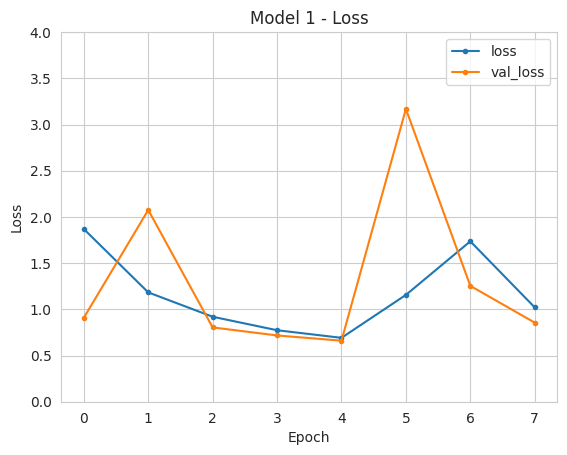

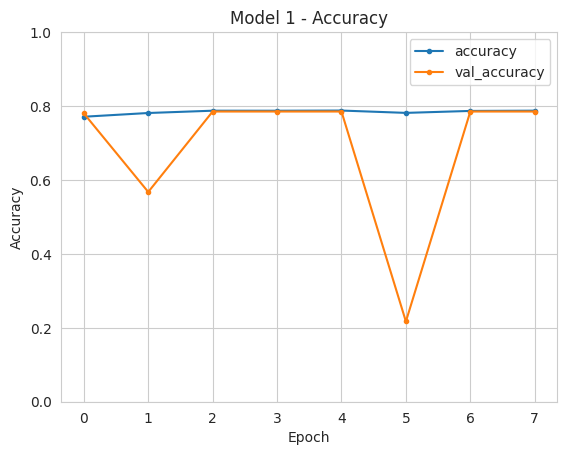

In [23]:
history_tf_model_1 = joblib.load(os.path.join(output_path, "history_tf_model_1_walls.pkl"))
losses_1 = pd.DataFrame(history_tf_model_1)

losses_1[['loss', 'val_loss']].plot(style='.-')
plt.title("Model 1 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 4)  
plt.grid(True)
plt.savefig(f'{output_path}/model_1_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses_1[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Model 1 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)  
plt.grid(True)
plt.savefig(f'{output_path}/model_1_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

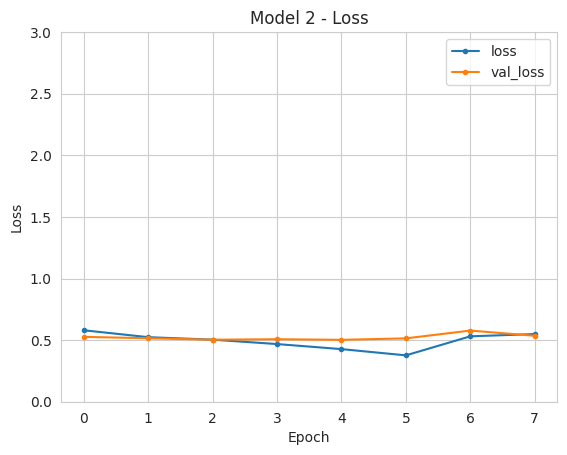

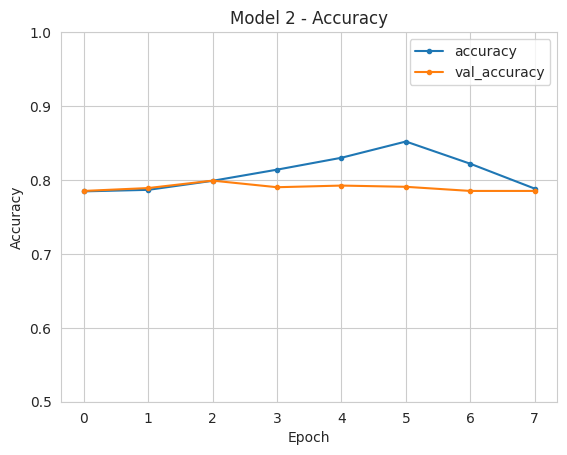

In [24]:
history_tf_model_2 = joblib.load(os.path.join(output_path, "history_tf_model_2_walls.pkl"))
losses_2 = pd.DataFrame(history_tf_model_2)

losses_2[['loss', 'val_loss']].plot(style='.-')
plt.title("Model 2 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 3)
plt.grid(True)
plt.savefig(f'{output_path}/model_2_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses_2[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Model 2 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.savefig(f'{output_path}/model_2_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

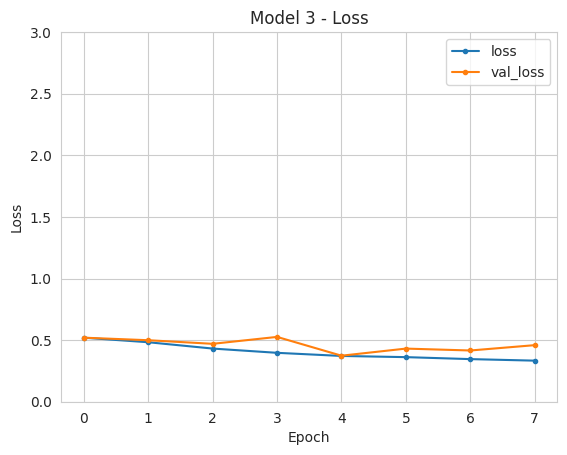

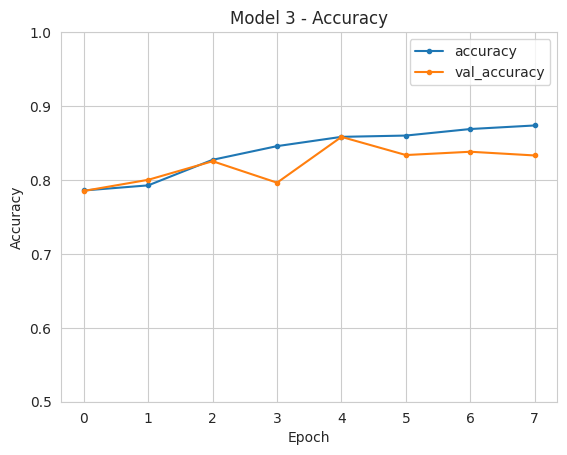

In [25]:
history_tf_model_3 = joblib.load(os.path.join(output_path, "history_tf_model_3_walls.pkl"))
losses_3 = pd.DataFrame(history_tf_model_3)

losses_3[['loss', 'val_loss']].plot(style='.-')
plt.title("Model 3 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 3)
plt.grid(True)
plt.savefig(f'{output_path}/model_3_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses_3[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Model 3 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.savefig(f'{output_path}/model_3_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

Evaluation

Model 1

In [31]:
model_1 = load_model('outputs/v1/tf_model_1_walls.h5')
evaluation_1 = model_1.evaluate(walls_test_gen)
print("Model 1 Evaluation:", evaluation_1)

114/114 [==============================] - 91s 794ms/step - loss: 0.6558 - accuracy: 0.7876
Model 1 Evaluation: [0.6557583808898926, 0.7876033186912537]


In [32]:
joblib.dump(value=evaluation_1, filename='outputs/v1/evaluation_tf_model_1_walls.pkl')
print("Model 1 evaluation saved.")

Model 1 evaluation saved.


Model 2

In [33]:
model_2 = load_model('outputs/v1/tf_model_2_walls.h5')
evaluation_2 = model_2.evaluate(walls_test_gen)
print("Model 2 Evaluation:", evaluation_2)

114/114 [==============================] - 54s 476ms/step - loss: 0.5030 - accuracy: 0.7970
Model 2 Evaluation: [0.503033459186554, 0.7969697117805481]


In [34]:
joblib.dump(value=evaluation_2, filename='outputs/v1/evaluation_tf_model_2_walls.pkl')
print("Model 2 evaluation saved.")

Model 2 evaluation saved.


Model 3

In [35]:
model_3 = load_model('outputs/v1/tf_model_3_walls.h5')
evaluation_3 = model_3.evaluate(walls_test_gen)
print("Model 3 Evaluation:", evaluation_3)

114/114 [==============================] - 86s 744ms/step - loss: 0.3677 - accuracy: 0.8653
Model 3 Evaluation: [0.36774319410324097, 0.8652892708778381]


In [36]:
joblib.dump(value=evaluation_3, filename='outputs/v1/evaluation_tf_model_3_walls.pkl')
print("Model 3 evaluation saved.")

Model 3 evaluation saved.


Prediction

Label: Cracked
All Labels: ['Cracked', 'Non-cracked']
Image shape: (256, 256), Image mode: RGB


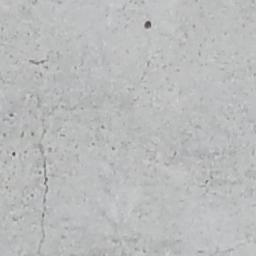

In [37]:
from tensorflow.keras.preprocessing import image

pointer = 19  
label = labels[0]  
print(f"Label: {label}")
print(f"All Labels: {labels}")

img_path = os.path.join(test_path, 'Walls', label, os.listdir(os.path.join(test_path, 'Walls', label))[pointer])
pil_image = image.load_img(img_path, target_size=image_shape, color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [38]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  

print("Image array shape for prediction:", my_image.shape)

Image array shape for prediction: (1, 256, 256, 3)


In [42]:
from tensorflow.keras.models import load_model

tf_model_1 = load_model(os.path.join(output_path, "tf_model_1_walls.h5"))
tf_model_2 = load_model(os.path.join(output_path, "tf_model_2_walls.h5"))
tf_model_3 = load_model(os.path.join(output_path, "tf_model_3_walls.h5"))

In [43]:
target_map = {v: k for k, v in class_indices.items()}
print(f"Target map is: {target_map}")

pred_proba_model_1 = tf_model_1.predict(my_image)[0][0]
print(f"Model 1 predicts: {pred_proba_model_1:.4f} ({target_map[int(pred_proba_model_1 > 0.5)]})")

pred_proba_model_2 = tf_model_2.predict(my_image)[0][0]
print(f"Model 2 predicts: {pred_proba_model_2:.4f} ({target_map[int(pred_proba_model_2 > 0.5)]})")

pred_proba_model_3 = tf_model_3.predict(my_image)[0][0]
print(f"Model 3 predicts: {pred_proba_model_3:.4f} ({target_map[int(pred_proba_model_3 > 0.5)]})")

Target map is: {0: 'Cracked', 1: 'Non-cracked'}
Model 1 predicts: 0.7207 (Non-cracked)
Model 2 predicts: 0.7414 (Non-cracked)
Model 3 predicts: 0.1634 (Cracked)


In [44]:
prob_per_class_model_1 = pd.DataFrame({
    'Cracked': [round(1 - pred_proba_model_1, 3)],
    'Non-cracked': [round(pred_proba_model_1, 3)]
})

prob_per_class_model_2 = pd.DataFrame({
    'Cracked': [round(1 - pred_proba_model_2, 3)],
    'Non-cracked': [round(pred_proba_model_2, 3)]
})

prob_per_class_model_3 = pd.DataFrame({
    'Cracked': [round(1 - pred_proba_model_3, 3)],
    'Non-cracked': [round(pred_proba_model_3, 3)]
})

print("Model 1:")
print(prob_per_class_model_1)
print('=========================')

print("Model 2:")
print(prob_per_class_model_2)
print('=========================')

print("Model 3:")
print(prob_per_class_model_3)

Model 1:
   Cracked  Non-cracked
0    0.279        0.721
Model 2:
   Cracked  Non-cracked
0    0.259        0.741
Model 3:
   Cracked  Non-cracked
0    0.837        0.163
